# Backtesting for Options Strategy

This notebook is created to test short-options (theta) strategies, such as the one used by QYLD.

The methodology is as follows:
- Use a statistical distribution based on historical SPY prices to generate series of daily close prices.
- Use the Black-Scholes-Merton equation to evaluate options and trade them according to stated strategy.
- Do Monte Carlo simulations to evaluate the returns of each strategy.

In [1]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from scipy.stats import laplace, norm
from tqdm.notebook import tqdm

pd.options.display.max_columns=300
pd.options.display.max_rows=100




### Dataset
Dataset is SPY (S&P 500 ETF). We take closing prices from yahoo finance.

In [2]:
misc.get_price_data('SPY')
df = pd.read_csv('SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')
df['close daily returns'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
df = df.dropna()

df

,open,high,low,close,adjclose,volume,ticker,close daily returns
date,,,,,,,,
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397591,480500,SPY,0.007112
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451389,201300,SPY,0.002119
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720442,529400,SPY,0.010571
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828043,531500,SPY,0.004184
1993-02-05,44.968750,45.062500,44.718750,44.968750,25.810122,492100,SPY,-0.000694
...,...,...,...,...,...,...,...,...
2023-01-06,382.609985,389.250000,379.410004,388.079987,388.079987,104041300,SPY,0.022932
2023-01-09,390.369995,393.700012,387.670013,387.859985,387.859985,73978100,SPY,-0.000567
2023-01-10,387.250000,390.649994,386.269989,390.579987,390.579987,65358100,SPY,0.007013


### Statistics of SPY

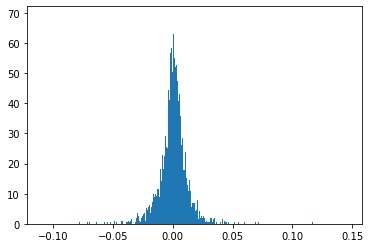

In [3]:
# Distribution of daily returns
count, bins, ignored = plt.hist(df['close daily returns'], 1000, density=True)

Normal distribution:

(0.0003632708204321383, 0.011945985944764903)


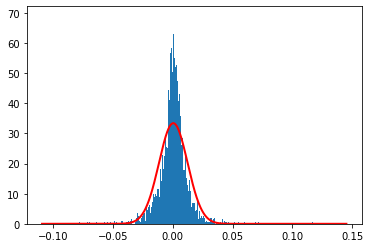

In [4]:
# Fit normal distribution parameters
norm_params = norm.fit(df['close daily returns'])
print(norm_params)

# Plot daily return distribution
count, bins, ignored = plt.hist(df['close daily returns'], 1000, density=True)

# Plot normal distribution with parameters
mu, sigma = norm_params
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

Laplace Distribution:

https://arxiv.org/ftp/arxiv/papers/1906/1906.10325.pdf

(0.0005981412593033632, 0.007938323535225484)


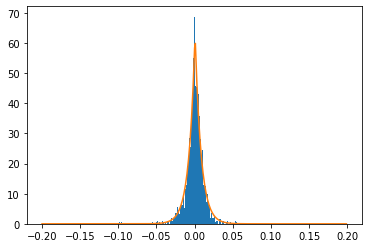

In [5]:
# Fit Laplace distribution parameters
laplace_params = laplace.fit(df['close daily returns'])
print(laplace_params)

# Plot daily returns distribution
count, bins, ignored = plt.hist(df['close daily returns'], 1000, density=True)

# Plot Laplace distribution with parameters
loc, scale = laplace_params
x = np.arange(-0.2, 0.2, .001)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)

The laplace distribution appears to be fit SPY daily returns distribution more closely.

We calculate the historical volatility of SPY for use in the BSM equation.

\begin{equation}
    \sigma_{annual} = \sigma_{daily} \times \sqrt{252}
\end{equation}

In [6]:
spy_hist_vol = np.std(df['close daily returns']) * np.sqrt(252)
print("SPY Historical Volatility: " + "{:.2f}".format(spy_hist_vol * 100) + " %")

SPY Historical Volatility: 18.96 %


### Model Stock Replication

We create a model stock by:
- Generating a random series of daily returns distributed by the laplace distribution with previously fitted parameters.
- Specify an initial price.
- Calculate subsequent closing prices by multiplying by daily returns

In [7]:
def generate_stock(laplace_params, num_days, initial_price):
    '''
    Generate array of stock prices according to laplace distribution
    '''
    # laplace parameters
    loc, scale = laplace_params
    
    # generate daily returns from laplace distribution
    s = np.random.laplace(loc, scale, num_days)
    
    # generate stock price from daily returns
    stock_arr = [initial_price]
    for i in range(num_days):
        stock_arr.append(stock_arr[-1] * (1 + s[i]))
        
    return stock_arr

### Black-Scholes-Merton Equation
BSM equation:

\begin{equation}
    C = N(d_1)S - N(d_2)Ke^{-rt}
\end{equation}

where
- $d_1 = \frac{\ln \frac{S}{K} + (r + \frac{\sigma^2}{2})t}{\sigma\sqrt{t}}$
- $d_2 = d_1 - \sigma\sqrt{t}$
- $C$ is the call option price.
- $N(x)$ is the cummulative distribution function of the normal distribution.
- $S$ is the current price of the underlying.
- $K$ is the strike price of the contract.
- $r$ is the risk-free interest rate (taken as 1 Year US Treasury Bill, $r = 3.26\%$).
- $t$ is the time to maturity.
- $\sigma$ is the volatility.

The BSM equation makes several assumptions:
- Options are european styled, i.e. they cannot be exercised before expiration.
- Volatility remains constant throughout the lifetime of the option.

We are also assuming that the risk-free rate is appropriate as the option premiums and hence the returns of the strategy are highly dependent on the risk-free rate.

In [8]:
def bsm(stock_price, strike_price, dte, volatility=spy_hist_vol, rf_rate=0.0326):
    '''
    Calculate the delta and prices of call/put option according to BSM eqn.
    
    Input:
    - current stock price of underlying
    - strike price of contract
    - days to expiry (dte)
    - volatility (historically 17.73% for SPY)
    - risk-free interest rate (3.26% for 1 Year US Treasury Bill)
    
    Output:
    - delta of call option
    - price of call option
    - delta of put option
    - price of put option
    '''
    
    # change units for dte to years
    t = dte / 365.25
    
    # present value of strike price
    pv_strike = strike_price * np.exp(-rf_rate * t)
    
    # d1 and d2 variables of bsm
    d1 = (np.log(stock_price / strike_price) \
          + (rf_rate + (volatility ** 2) / 2) * t) / (volatility * np.sqrt(t))
    d2 = d1 - volatility * np.sqrt(t)
    
    # delta of call option
    call_delta = norm.cdf(d1)
    
    # price of call option
    call_price = call_delta * stock_price - norm.cdf(d2) * pv_strike
    
    # delta of put option
    put_delta = -norm.cdf(-d1)
    
    # price of put option
    put_price = put_delta * stock_price + norm.cdf(-d2) * pv_strike
    
    return call_delta * 100, call_price * 100, put_delta * 100, put_price * 100

### QYLD strategy

The strategy of the QYLD fund is to hold assets in the underlying index and sell ATM covered calls every month to generate income with the option premium. This strategy is supposed to generate consistent returns with low volatility, although it caps the upside.

Note that since we are using a simulated SPY underlying, we are actually exploring performance of the XYLD fund, but we shall call this the QYLD strategy as it is the most well-known fund.

In [9]:
def qyld_option():
    pass

def generate_case_qyld():
    num_days = 500
    initial_price = 400
    initial_capital = 100000
    dte = 45
    
    stock = generate_stock(laplace_params, num_days=num_days, initial_price=initial_price)
    df = pd.DataFrame({'close': stock})
    
    df['cash_position'] = initial_capital
    df['stock_position'] = 0
    df['call_position'] = 0
    df['call_strike'] = 0
    df['call_dte'] = 0
    df['call_value'] = 0
#     df['put_position'] = 0
#     df['put-strike'] = 0
#     df['put_dte'] = 0
#     df['put_value'] = 0
    df['stock_value'] = 0
    
    stock_pos = 0
    call_pos = 0
    cash_pos = initial_capital
    for i in range(1, num_days):
        if i % (dte + 1) == 1:
            if call_pos != 0:
                # close call on expiry date
                # if call is OTM
                if strike > df['close'][i]:
                    # OTM calls expire worthless
                    print('calls expire worthless')
                    call_pos = 0
                    call_value = 0
                else:
                    # ITM calls are exercised
                    call_pos = 0
                    call_value = 0
                    
                    print('calls expire ITM')
                    print(f'--- cost_basis = {cost_basis}')
                    print(f'--- {stock_pos} @ {strike}')
                    print(f'--- cash is {cash_pos}')
                    cash_pos += stock_pos * strike
                    print(f'--- cash is {cash_pos}')
                    stock_pos = 0
            if stock_pos == 0:
                # day 1
                # buy stock
                blocks = np.floor(cash_pos / (df['close'][i] * 100))
                stock_pos = blocks * 100
                
                print('buy stock')
                cost_basis = df['close'][i]
                print(f'--- {stock_pos} @ {df["close"][i]}')
                print(f'--- cash is {cash_pos}')
                cash_pos -= stock_pos * df['close'][i]
                print(f'--- cash is {cash_pos}')
                
                
            # sell call
            print('selling call')
            strike = np.ceil(df['close'][i])
            print(f'--- strike is {strike}')
            option_data = bsm(
                stock_price=df['close'][i],
                strike_price=strike,
                dte=dte
            )
            call_price = option_data[1]
            print(f'--- call price {call_price}')
            call_pos = -stock_pos/100
            print(f'--- call pos {call_pos}')
            call_value = call_pos * call_price
            print(f'--- cash is {cash_pos}')
            cash_pos += -call_value
            print(f'--- cash is {cash_pos}')
            df.loc[i, 'call_dte'] = dte
            df.loc[i, 'call_value'] = call_value
            
            
        else:
            # update call value
            df.loc[i, 'call_dte'] = df['call_dte'][i - 1] - 1
            call_value = bsm(
                stock_price=df['close'][i],
                strike_price=strike,
                dte=dte
            )[1] * call_pos
            
            
            
        # input data to dataframe
        df.loc[i, 'call_strike'] = strike
        df.loc[i, 'cash_position'] = cash_pos
        df.loc[i, 'stock_position'] = stock_pos
        df.loc[i, 'call_position'] = call_pos
        df.loc[i, 'call_value'] = call_value
        
        
    df.loc[num_days, 'stock_position'] = df['stock_position'][num_days - 1]
    df.loc[num_days, 'cash_position'] = df['cash_position'][num_days - 1] + df['call_value'][num_days - 1]
    df.loc[num_days, 'call_value'] = 0
    
    df['stock_value'] = df['stock_position'] * df['close']
    df['total_value'] = df['cash_position'] \
        + df['call_value'] \
        + df['stock_value']
    
    buy_hold_return = (df['close'][num_days] - df['close'][0])/ df['close'][0]
    strategy_return = (df['total_value'][num_days] - df['total_value'][0])/ df['total_value'][0]
    print(f'buy_hold_return = {buy_hold_return * 100}')
    print(f'strategy_return = {strategy_return * 100}')
    
    return buy_hold_return, strategy_return

        
    
    
    
    
    
    



# bsm_equation(stock_price=400, strike_price=410, dte=30, volatility=0.2, rf_rate=0.026)
generate_case_qyld()

buy stock
--- 200.0 @ 401.83041126136317
--- cash is 100000
--- cash is 19633.917747727362
selling call
--- strike is 402.0
--- call price 1138.5834404721236
--- call pos -2.0
--- cash is 19633.917747727362
--- cash is 21911.08462867161
calls expire worthless
selling call
--- strike is 392.0
--- call price 1076.579560192161
--- call pos -2.0
--- cash is 21911.08462867161
--- cash is 24064.24374905593
calls expire ITM
--- cost_basis = 401.83041126136317
--- 200.0 @ 392.0
--- cash is 24064.24374905593
--- cash is 102464.24374905592
buy stock
--- 200.0 @ 416.31878075824795
--- cash is 102464.24374905592
--- cash is 19200.487597406332
selling call
--- strike is 417.0
--- call price 1154.2285369121657
--- call pos -2.0
--- cash is 19200.487597406332
--- cash is 21508.944671230664
calls expire ITM
--- cost_basis = 416.31878075824795
--- 200.0 @ 417.0
--- cash is 21508.944671230664
--- cash is 104908.94467123067
buy stock
--- 200.0 @ 433.67835096536817
--- cash is 104908.94467123067
--- cash 

(0.00017701645942878487, 0.018479835590576404)

In [10]:
buy_hold_results = []
strategy_results = []
for i in tqdm(range(100)):
    bh, st = generate_case_qyld()
    buy_hold_results.append(bh)
    strategy_results.append(st)
    




    

  0%|          | 0/100 [00:00<?, ?it/s]

buy stock
--- 200.0 @ 401.02545627099903
--- cash is 100000
--- cash is 19794.90874580019
selling call
--- strike is 402.0
--- call price 1096.0184281523339
--- call pos -2.0
--- cash is 19794.90874580019
--- cash is 21986.945602104857
calls expire ITM
--- cost_basis = 401.02545627099903
--- 200.0 @ 402.0
--- cash is 21986.945602104857
--- cash is 102386.94560210485
buy stock
--- 200.0 @ 443.711191738018
--- cash is 102386.94560210485
--- cash is 13644.707254501263
selling call
--- strike is 444.0
--- call price 1252.1187992462728
--- call pos -2.0
--- cash is 13644.707254501263
--- cash is 16148.944852993809
calls expire ITM
--- cost_basis = 443.711191738018
--- 200.0 @ 444.0
--- cash is 16148.944852993809
--- cash is 104948.94485299381
buy stock
--- 200.0 @ 463.73623206651115
--- cash is 104948.94485299381
--- cash is 12201.69843969158
selling call
--- strike is 464.0
--- call price 1310.5510914344309
--- call pos -2.0
--- cash is 12201.69843969158
--- cash is 14822.80062256044
calls

calls expire ITM
--- cost_basis = 408.9689832128523
--- 200.0 @ 400.0
--- cash is 25838.951968849888
--- cash is 105838.95196884988
buy stock
--- 200.0 @ 442.66722834908575
--- cash is 105838.95196884988
--- cash is 17305.506299032728
selling call
--- strike is 443.0
--- call price 1246.9203036883273
--- call pos -2.0
--- cash is 17305.506299032728
--- cash is 19799.34690640938
calls expire worthless
selling call
--- strike is 432.0
--- call price 1205.3473092435752
--- call pos -2.0
--- cash is 19799.34690640938
--- cash is 22210.04152489653
calls expire ITM
--- cost_basis = 442.66722834908575
--- 200.0 @ 432.0
--- cash is 22210.04152489653
--- cash is 108610.04152489653
buy stock
--- 200.0 @ 445.73872099894754
--- cash is 108610.04152489653
--- cash is 19462.29732510702
selling call
--- strike is 446.0
--- call price 1259.297364490399
--- call pos -2.0
--- cash is 19462.29732510702
--- cash is 21980.89205408782
calls expire worthless
selling call
--- strike is 400.0
--- call price 11

calls expire ITM
--- cost_basis = 430.5862657215114
--- 200.0 @ 431.0
--- cash is 14654.086479291393
--- cash is 100854.08647929139
buy stock
--- 200.0 @ 441.83700053904226
--- cash is 100854.08647929139
--- cash is 12486.686371482938
selling call
--- strike is 442.0
--- call price 1253.1304849663172
--- call pos -2.0
--- cash is 12486.686371482938
--- cash is 14992.947341415573
calls expire ITM
--- cost_basis = 441.83700053904226
--- 200.0 @ 442.0
--- cash is 14992.947341415573
--- cash is 103392.94734141557
buy stock
--- 200.0 @ 476.1628381484739
--- cash is 103392.94734141557
--- cash is 8160.379711720787
selling call
--- strike is 477.0
--- call price 1317.2509577661629
--- call pos -2.0
--- cash is 8160.379711720787
--- cash is 10794.881627253113
calls expire ITM
--- cost_basis = 476.1628381484739
--- 200.0 @ 477.0
--- cash is 10794.881627253113
--- cash is 106194.88162725311
buy stock
--- 200.0 @ 526.0458138404546
--- cash is 106194.88162725311
--- cash is 985.7188591621962
selli

calls expire worthless
selling call
--- strike is 822.0
--- call price 2306.810658372922
--- call pos -1.0
--- cash is 30445.1918704996
--- cash is 32752.00252887252
calls expire worthless
selling call
--- strike is 787.0
--- call price 2240.308612425514
--- call pos -1.0
--- cash is 32752.00252887252
--- cash is 34992.311141298036
buy_hold_return = 111.38444876939278
strategy_return = 11.276653834163197
buy stock
--- 200.0 @ 395.311913383758
--- cash is 100000
--- cash is 20937.6173232484
selling call
--- strike is 396.0
--- call price 1093.9311877847501
--- call pos -2.0
--- cash is 20937.6173232484
--- cash is 23125.4796988179
calls expire ITM
--- cost_basis = 395.311913383758
--- 200.0 @ 396.0
--- cash is 23125.4796988179
--- cash is 102325.4796988179
buy stock
--- 200.0 @ 397.4224712761949
--- cash is 102325.4796988179
--- cash is 22840.985443578917
selling call
--- strike is 398.0
--- call price 1105.474347820342
--- call pos -2.0
--- cash is 22840.985443578917
--- cash is 25051.

calls expire ITM
--- cost_basis = 444.1791395946309
--- 200.0 @ 401.0
--- cash is 27349.232982749894
--- cash is 107549.23298274989
buy stock
--- 200.0 @ 419.31388058141454
--- cash is 107549.23298274989
--- cash is 23686.45686646698
selling call
--- strike is 420.0
--- call price 1162.5323752618044
--- call pos -2.0
--- cash is 23686.45686646698
--- cash is 26011.521616990587
calls expire ITM
--- cost_basis = 419.31388058141454
--- 200.0 @ 420.0
--- cash is 26011.521616990587
--- cash is 110011.52161699059
buy stock
--- 200.0 @ 431.07206471427406
--- cash is 110011.52161699059
--- cash is 23797.108674135772
selling call
--- strike is 432.0
--- call price 1184.0594789919521
--- call pos -2.0
--- cash is 23797.108674135772
--- cash is 26165.227632119677
calls expire ITM
--- cost_basis = 431.07206471427406
--- 200.0 @ 432.0
--- cash is 26165.227632119677
--- cash is 112565.22763211967
buy stock
--- 200.0 @ 450.93455227485725
--- cash is 112565.22763211967
--- cash is 22378.317177148216
s

calls expire ITM
--- cost_basis = 518.9631745866756
--- 200.0 @ 519.0
--- cash is 9184.386138550466
--- cash is 112984.38613855047
buy stock
--- 200.0 @ 543.1466593049666
--- cash is 112984.38613855047
--- cash is 4355.0542775571375
selling call
--- strike is 544.0
--- call price 1507.6215795953033
--- call pos -2.0
--- cash is 4355.0542775571375
--- cash is 7370.297436747744
calls expire ITM
--- cost_basis = 543.1466593049666
--- 200.0 @ 544.0
--- cash is 7370.297436747744
--- cash is 116170.29743674774
buy stock
--- 100.0 @ 599.3558547771283
--- cash is 116170.29743674774
--- cash is 56234.71195903491
selling call
--- strike is 600.0
--- call price 1678.5431720365239
--- call pos -1.0
--- cash is 56234.71195903491
--- cash is 57913.25513107143
buy_hold_return = 52.388035656721485
strategy_return = 15.815573264334395
buy stock
--- 200.0 @ 399.7799333342492
--- cash is 100000
--- cash is 20044.013333150157
selling call
--- strike is 400.0
--- call price 1130.1762514300917
--- call pos 

calls expire worthless
selling call
--- strike is 372.0
--- call price 1034.0718215286074
--- call pos -2.0
--- cash is 19344.08257051618
--- cash is 21412.226213573394
calls expire ITM
--- cost_basis = 448.7782668990826
--- 200.0 @ 372.0
--- cash is 21412.226213573394
--- cash is 95812.22621357339
buy stock
--- 200.0 @ 387.4140880480038
--- cash is 95812.22621357339
--- cash is 18329.408603972624
selling call
--- strike is 388.0
--- call price 1076.488788087545
--- call pos -2.0
--- cash is 18329.408603972624
--- cash is 20482.386180147714
calls expire ITM
--- cost_basis = 387.4140880480038
--- 200.0 @ 388.0
--- cash is 20482.386180147714
--- cash is 98082.38618014772
buy stock
--- 200.0 @ 388.4615187375308
--- cash is 98082.38618014772
--- cash is 20390.08243264156
selling call
--- strike is 389.0
--- call price 1081.850473806
--- call pos -2.0
--- cash is 20390.08243264156
--- cash is 22553.78338025356
calls expire worthless
selling call
--- strike is 324.0
--- call price 906.636641

buy_hold_return = 57.04609944047454
strategy_return = 6.5342713948015305
buy stock
--- 200.0 @ 403.4010378595719
--- cash is 100000
--- cash is 19319.792428085624
selling call
--- strike is 404.0
--- call price 1121.467135776379
--- call pos -2.0
--- cash is 19319.792428085624
--- cash is 21562.726699638384
calls expire ITM
--- cost_basis = 403.4010378595719
--- 200.0 @ 404.0
--- cash is 21562.726699638384
--- cash is 102362.72669963838
buy stock
--- 200.0 @ 405.63053538419103
--- cash is 102362.72669963838
--- cash is 21236.61962280018
selling call
--- strike is 406.0
--- call price 1139.3428812578718
--- call pos -2.0
--- cash is 21236.61962280018
--- cash is 23515.30538531592
calls expire ITM
--- cost_basis = 405.63053538419103
--- 200.0 @ 406.0
--- cash is 23515.30538531592
--- cash is 104715.30538531592
buy stock
--- 200.0 @ 442.61747985891526
--- cash is 104715.30538531592
--- cash is 16191.809413532872
selling call
--- strike is 443.0
--- call price 1244.2713305095936
--- call p

calls expire ITM
--- cost_basis = 566.4089283033563
--- 200.0 @ 567.0
--- cash is 4755.9697355039425
--- cash is 118155.96973550394
buy stock
--- 100.0 @ 652.0419898312648
--- cash is 118155.96973550394
--- cash is 52951.77075237746
selling call
--- strike is 653.0
--- call price 1813.2029340753547
--- call pos -1.0
--- cash is 52951.77075237746
--- cash is 54764.97368645282
calls expire worthless
selling call
--- strike is 652.0
--- call price 1837.6675533551236
--- call pos -1.0
--- cash is 54764.97368645282
--- cash is 56602.64123980794
buy_hold_return = 93.64344555868601
strategy_return = 22.770210900483043
buy stock
--- 200.0 @ 399.0880808183179
--- cash is 100000
--- cash is 20182.38383633642
selling call
--- strike is 400.0
--- call price 1093.5885783198216
--- call pos -2.0
--- cash is 20182.38383633642
--- cash is 22369.56099297606
calls expire worthless
selling call
--- strike is 358.0
--- call price 1016.3266734236515
--- call pos -2.0
--- cash is 22369.56099297606
--- cash 

calls expire worthless
selling call
--- strike is 257.0
--- call price 727.2184081152318
--- call pos -2.0
--- cash is 28836.54183672283
--- cash is 30290.978652953294
calls expire ITM
--- cost_basis = 307.79294718680706
--- 200.0 @ 257.0
--- cash is 30290.978652953294
--- cash is 81690.97865295329
buy stock
--- 200.0 @ 284.083858971602
--- cash is 81690.97865295329
--- cash is 24874.206858632882
selling call
--- strike is 285.0
--- call price 765.3064338508585
--- call pos -2.0
--- cash is 24874.206858632882
--- cash is 26404.8197263346
calls expire ITM
--- cost_basis = 284.083858971602
--- 200.0 @ 285.0
--- cash is 26404.8197263346
--- cash is 83404.8197263346
buy stock
--- 200.0 @ 299.04152436843833
--- cash is 83404.8197263346
--- cash is 23596.514852646927
selling call
--- strike is 300.0
--- call price 805.890539071379
--- call pos -2.0
--- cash is 23596.514852646927
--- cash is 25208.295930789685
buy_hold_return = -27.46483965532047
strategy_return = -17.597183869136455
buy stoc

calls expire worthless
selling call
--- strike is 538.0
--- call price 1523.9979804413508
--- call pos -2.0
--- cash is 7261.635959235832
--- cash is 10309.631920118534
calls expire worthless
selling call
--- strike is 533.0
--- call price 1519.7374600892317
--- call pos -2.0
--- cash is 10309.631920118534
--- cash is 13349.106840296998
calls expire worthless
selling call
--- strike is 479.0
--- call price 1352.6698912051784
--- call pos -2.0
--- cash is 13349.106840296998
--- cash is 16054.446622707354
calls expire worthless
selling call
--- strike is 466.0
--- call price 1325.9459601393814
--- call pos -2.0
--- cash is 16054.446622707354
--- cash is 18706.338542986115
calls expire ITM
--- cost_basis = 544.4090979792428
--- 200.0 @ 466.0
--- cash is 18706.338542986115
--- cash is 111906.33854298611
buy stock
--- 200.0 @ 500.64175610512706
--- cash is 111906.33854298611
--- cash is 11777.987321960696
selling call
--- strike is 501.0
--- call price 1411.1383466764692
--- call pos -2.0
-

calls expire worthless
selling call
--- strike is 360.0
--- call price 995.6018537180597
--- call pos -2.0
--- cash is 22655.610708372922
--- cash is 24646.81441580904
calls expire worthless
selling call
--- strike is 349.0
--- call price 987.4027240079698
--- call pos -2.0
--- cash is 24646.81441580904
--- cash is 26621.61986382498
calls expire worthless
selling call
--- strike is 317.0
--- call price 901.8627668420891
--- call pos -2.0
--- cash is 26621.61986382498
--- cash is 28425.345397509158
calls expire ITM
--- cost_basis = 408.65917946940726
--- 200.0 @ 317.0
--- cash is 28425.345397509158
--- cash is 91825.34539750915
buy stock
--- 200.0 @ 336.0176748259781
--- cash is 91825.34539750915
--- cash is 24621.810432313534
selling call
--- strike is 337.0
--- call price 910.1811633655103
--- call pos -2.0
--- cash is 24621.810432313534
--- cash is 26442.172759044555
calls expire worthless
selling call
--- strike is 309.0
--- call price 858.4806157233373
--- call pos -2.0
--- cash is

calls expire ITM
--- cost_basis = 544.5654769337992
--- 200.0 @ 545.0
--- cash is 3294.7362597819397
--- cash is 112294.73625978194
buy stock
--- 100.0 @ 586.4575273585765
--- cash is 112294.73625978194
--- cash is 53648.9835239243
selling call
--- strike is 587.0
--- call price 1646.835336724962
--- call pos -1.0
--- cash is 53648.9835239243
--- cash is 55295.81886064926
buy_hold_return = 56.787278224896056
strategy_return = 14.048614065195842
buy stock
--- 200.0 @ 399.67900003396204
--- cash is 100000
--- cash is 20064.199993207585
selling call
--- strike is 400.0
--- call price 1124.7939219178363
--- call pos -2.0
--- cash is 20064.199993207585
--- cash is 22313.78783704326
calls expire ITM
--- cost_basis = 399.67900003396204
--- 200.0 @ 400.0
--- cash is 22313.78783704326
--- cash is 102313.78783704326
buy stock
--- 200.0 @ 462.0595618491839
--- cash is 102313.78783704326
--- cash is 9901.875467206468
selling call
--- strike is 463.0
--- call price 1271.8650774899943
--- call pos -

calls expire ITM
--- cost_basis = 541.2052131982082
--- 200.0 @ 542.0
--- cash is 11001.426094554243
--- cash is 119401.42609455425
buy stock
--- 100.0 @ 622.2474303741662
--- cash is 119401.42609455425
--- cash is 57176.68305713763
selling call
--- strike is 623.0
--- call price 1738.4455124598787
--- call pos -1.0
--- cash is 57176.68305713763
--- cash is 58915.1285695975
buy_hold_return = 63.575202061009094
strategy_return = 20.751062424868113
buy stock
--- 200.0 @ 401.9326499677489
--- cash is 100000
--- cash is 19613.470006450225
selling call
--- strike is 402.0
--- call price 1144.0586909007038
--- call pos -2.0
--- cash is 19613.470006450225
--- cash is 21901.58738825163
calls expire ITM
--- cost_basis = 401.9326499677489
--- 200.0 @ 402.0
--- cash is 21901.58738825163
--- cash is 102301.58738825163
buy stock
--- 200.0 @ 414.922061370765
--- cash is 102301.58738825163
--- cash is 19317.17511409863
selling call
--- strike is 415.0
--- call price 1180.6046075704076
--- call pos -2

calls expire ITM
--- cost_basis = 441.7624834772127
--- 200.0 @ 425.0
--- cash is 23710.052667038854
--- cash is 108710.05266703885
buy stock
--- 200.0 @ 456.25778445788006
--- cash is 108710.05266703885
--- cash is 17458.49577546284
selling call
--- strike is 457.0
--- call price 1265.1753093042544
--- call pos -2.0
--- cash is 17458.49577546284
--- cash is 19988.84639407135
calls expire ITM
--- cost_basis = 456.25778445788006
--- 200.0 @ 457.0
--- cash is 19988.84639407135
--- cash is 111388.84639407136
buy stock
--- 200.0 @ 461.55123524901524
--- cash is 111388.84639407136
--- cash is 19078.59934426831
selling call
--- strike is 462.0
--- call price 1294.9868811778488
--- call pos -2.0
--- cash is 19078.59934426831
--- cash is 21668.573106624008
calls expire ITM
--- cost_basis = 461.55123524901524
--- 200.0 @ 462.0
--- cash is 21668.573106624008
--- cash is 114068.57310662401
buy stock
--- 200.0 @ 479.5861104521008
--- cash is 114068.57310662401
--- cash is 18151.35101620386
selling

calls expire ITM
--- cost_basis = 431.94512559294304
--- 200.0 @ 432.0
--- cash is 8940.929086876495
--- cash is 95340.9290868765
buy stock
--- 200.0 @ 442.95101992719907
--- cash is 95340.9290868765
--- cash is 6750.7251014366775
selling call
--- strike is 443.0
--- call price 1262.095278014749
--- call pos -2.0
--- cash is 6750.7251014366775
--- cash is 9274.915657466176
calls expire ITM
--- cost_basis = 442.95101992719907
--- 200.0 @ 443.0
--- cash is 9274.915657466176
--- cash is 97874.91565746618
buy stock
--- 100.0 @ 496.8775367607658
--- cash is 97874.91565746618
--- cash is 48187.161981389596
selling call
--- strike is 497.0
--- call price 1412.3196174230116
--- call pos -1.0
--- cash is 48187.161981389596
--- cash is 49599.48159881261
calls expire ITM
--- cost_basis = 496.8775367607658
--- 100.0 @ 497.0
--- cash is 49599.48159881261
--- cash is 99299.4815988126
buy stock
--- 100.0 @ 515.2835018099346
--- cash is 99299.4815988126
--- cash is 47771.131417819146
selling call
--- 

calls expire ITM
--- cost_basis = 476.28739893469344
--- 200.0 @ 442.0
--- cash is 12385.977025616176
--- cash is 100785.97702561617
buy stock
--- 100.0 @ 518.4018530780996
--- cash is 100785.97702561617
--- cash is 48945.791717806205
selling call
--- strike is 519.0
--- call price 1449.7662534721655
--- call pos -1.0
--- cash is 48945.791717806205
--- cash is 50395.55797127837
calls expire ITM
--- cost_basis = 518.4018530780996
--- 100.0 @ 519.0
--- cash is 50395.55797127837
--- cash is 102295.55797127838
buy stock
--- 100.0 @ 558.8655834011123
--- cash is 102295.55797127838
--- cash is 46408.99963116715
selling call
--- strike is 559.0
--- call price 1588.6824586689954
--- call pos -1.0
--- cash is 46408.99963116715
--- cash is 47997.68208983615
calls expire worthless
selling call
--- strike is 509.0
--- call price 1449.3556050454174
--- call pos -1.0
--- cash is 47997.68208983615
--- cash is 49447.03769488157
calls expire ITM
--- cost_basis = 558.8655834011123
--- 100.0 @ 509.0
--- 

calls expire ITM
--- cost_basis = 399.84213405550395
--- 200.0 @ 400.0
--- cash is 24488.84075702661
--- cash is 104488.84075702661
buy stock
--- 200.0 @ 428.7333671813994
--- cash is 104488.84075702661
--- cash is 18742.16732074674
selling call
--- strike is 429.0
--- call price 1210.4800070001288
--- call pos -2.0
--- cash is 18742.16732074674
--- cash is 21163.127334746998
calls expire ITM
--- cost_basis = 428.7333671813994
--- 200.0 @ 429.0
--- cash is 21163.127334746998
--- cash is 106963.127334747
buy stock
--- 200.0 @ 483.2958556922464
--- cash is 106963.127334747
--- cash is 10303.956196297717
selling call
--- strike is 484.0
--- call price 1344.2493265127496
--- call pos -2.0
--- cash is 10303.956196297717
--- cash is 12992.454849323216
calls expire ITM
--- cost_basis = 483.2958556922464
--- 200.0 @ 484.0
--- cash is 12992.454849323216
--- cash is 109792.45484932321
buy stock
--- 200.0 @ 536.5421339326557
--- cash is 109792.45484932321
--- cash is 2484.028062792073
selling cal

calls expire worthless
selling call
--- strike is 356.0
--- call price 995.100965826677
--- call pos -2.0
--- cash is 29891.13474934666
--- cash is 31881.336681000015
calls expire ITM
--- cost_basis = 380.9005041413255
--- 200.0 @ 356.0
--- cash is 31881.336681000015
--- cash is 103081.33668100002
buy stock
--- 200.0 @ 373.3263814993703
--- cash is 103081.33668100002
--- cash is 28416.06038112595
selling call
--- strike is 374.0
--- call price 1031.9058133091885
--- call pos -2.0
--- cash is 28416.06038112595
--- cash is 30479.87200774433
calls expire worthless
selling call
--- strike is 350.0
--- call price 964.8671000110511
--- call pos -2.0
--- cash is 30479.87200774433
--- cash is 32409.606207766432
buy_hold_return = -6.690507732208843
strategy_return = 2.4313504236808803
buy stock
--- 200.0 @ 392.2672480061953
--- cash is 100000
--- cash is 21546.55039876094
selling call
--- strike is 393.0
--- call price 1083.0176165654166
--- call pos -2.0
--- cash is 21546.55039876094
--- cash 

calls expire ITM
--- cost_basis = 442.7278798788488
--- 200.0 @ 428.0
--- cash is 13988.483962617069
--- cash is 99588.48396261707
buy stock
--- 100.0 @ 498.32379752514095
--- cash is 99588.48396261707
--- cash is 49756.104210102974
selling call
--- strike is 499.0
--- call price 1388.5419786240334
--- call pos -1.0
--- cash is 49756.104210102974
--- cash is 51144.646188727005
calls expire worthless
selling call
--- strike is 498.0
--- call price 1402.2764060631062
--- call pos -1.0
--- cash is 51144.646188727005
--- cash is 52546.922594790114
calls expire ITM
--- cost_basis = 498.32379752514095
--- 100.0 @ 498.0
--- cash is 52546.922594790114
--- cash is 102346.92259479011
buy stock
--- 100.0 @ 528.5687901921877
--- cash is 102346.92259479011
--- cash is 49490.04357557134
selling call
--- strike is 529.0
--- call price 1487.1838841726685
--- call pos -1.0
--- cash is 49490.04357557134
--- cash is 50977.22745974401
buy_hold_return = 47.61536637388883
strategy_return = 3.830126850787550

calls expire worthless
selling call
--- strike is 448.0
--- call price 1251.7086734852028
--- call pos -2.0
--- cash is 12055.731551782234
--- cash is 14559.148898752639
calls expire worthless
selling call
--- strike is 446.0
--- call price 1248.0941575477743
--- call pos -2.0
--- cash is 14559.148898752639
--- cash is 17055.337213848186
calls expire ITM
--- cost_basis = 474.2651366961149
--- 200.0 @ 446.0
--- cash is 17055.337213848186
--- cash is 106255.3372138482
buy stock
--- 200.0 @ 465.74353726923795
--- cash is 106255.3372138482
--- cash is 13106.629760000607
selling call
--- strike is 466.0
--- call price 1316.6507903555043
--- call pos -2.0
--- cash is 13106.629760000607
--- cash is 15739.931340711617
calls expire ITM
--- cost_basis = 465.74353726923795
--- 200.0 @ 466.0
--- cash is 15739.931340711617
--- cash is 108939.93134071161
buy stock
--- 200.0 @ 488.2134673673246
--- cash is 108939.93134071161
--- cash is 11297.237867246688
selling call
--- strike is 489.0
--- call pri

calls expire worthless
selling call
--- strike is 414.0
--- call price 1155.1297838994174
--- call pos -2.0
--- cash is 23390.100749087418
--- cash is 25700.360316886254
calls expire ITM
--- cost_basis = 414.6808676585752
--- 200.0 @ 414.0
--- cash is 25700.360316886254
--- cash is 108500.36031688625
buy stock
--- 200.0 @ 469.87138985184896
--- cash is 108500.36031688625
--- cash is 14526.082346516458
selling call
--- strike is 470.0
--- call price 1334.9082617674953
--- call pos -2.0
--- cash is 14526.082346516458
--- cash is 17195.89887005145
calls expire ITM
--- cost_basis = 469.87138985184896
--- 200.0 @ 470.0
--- cash is 17195.89887005145
--- cash is 111195.89887005145
buy stock
--- 200.0 @ 478.22468616415654
--- cash is 111195.89887005145
--- cash is 15550.961637220142
selling call
--- strike is 479.0
--- call price 1326.2197686946165
--- call pos -2.0
--- cash is 15550.961637220142
--- cash is 18203.401174609375
calls expire ITM
--- cost_basis = 478.22468616415654
--- 200.0 @ 47

calls expire ITM
--- cost_basis = 448.513667891546
--- 200.0 @ 449.0
--- cash is 18024.828055568603
--- cash is 107824.8280555686
buy stock
--- 200.0 @ 462.2663863906924
--- cash is 107824.8280555686
--- cash is 15371.550777430122
selling call
--- strike is 463.0
--- call price 1282.7540819303351
--- call pos -2.0
--- cash is 15371.550777430122
--- cash is 17937.058941290794
buy_hold_return = 34.01739939524586
strategy_return = 10.964664564181527
buy stock
--- 200.0 @ 401.40073205300837
--- cash is 100000
--- cash is 19719.85358939832
selling call
--- strike is 402.0
--- call price 1115.7424775586178
--- call pos -2.0
--- cash is 19719.85358939832
--- cash is 21951.338544515558
calls expire worthless
selling call
--- strike is 383.0
--- call price 1049.486231293804
--- call pos -2.0
--- cash is 21951.338544515558
--- cash is 24050.311007103166
calls expire worthless
selling call
--- strike is 379.0
--- call price 1063.0398250510411
--- call pos -2.0
--- cash is 24050.311007103166
--- c

calls expire ITM
--- cost_basis = 406.59015477816257
--- 200.0 @ 407.0
--- cash is 20962.07106329295
--- cash is 102362.07106329295
buy stock
--- 200.0 @ 426.7270268809973
--- cash is 102362.07106329295
--- cash is 17016.665687093497
selling call
--- strike is 427.0
--- call price 1204.432148957167
--- call pos -2.0
--- cash is 17016.665687093497
--- cash is 19425.52998500783
calls expire ITM
--- cost_basis = 426.7270268809973
--- 200.0 @ 427.0
--- cash is 19425.52998500783
--- cash is 104825.52998500783
buy stock
--- 200.0 @ 500.18414985956764
--- cash is 104825.52998500783
--- cash is 4788.700013094305
selling call
--- strike is 501.0
--- call price 1386.871803400686
--- call pos -2.0
--- cash is 4788.700013094305
--- cash is 7562.443619895677
calls expire ITM
--- cost_basis = 500.18414985956764
--- 200.0 @ 501.0
--- cash is 7562.443619895677
--- cash is 107762.44361989568
buy stock
--- 100.0 @ 545.1809094545139
--- cash is 107762.44361989568
--- cash is 53244.35267444429
selling cal

calls expire ITM
--- cost_basis = 464.25298605424064
--- 200.0 @ 464.0
--- cash is 18572.67553438639
--- cash is 111372.67553438639
buy stock
--- 200.0 @ 472.1315300505123
--- cash is 111372.67553438639
--- cash is 16946.36952428393
selling call
--- strike is 473.0
--- call price 1304.1866170837438
--- call pos -2.0
--- cash is 16946.36952428393
--- cash is 19554.74275845142
calls expire ITM
--- cost_basis = 472.1315300505123
--- 200.0 @ 473.0
--- cash is 19554.74275845142
--- cash is 114154.74275845142
buy stock
--- 200.0 @ 501.4107906932066
--- cash is 114154.74275845142
--- cash is 13872.584619810106
selling call
--- strike is 502.0
--- call price 1401.7136511300464
--- call pos -2.0
--- cash is 13872.584619810106
--- cash is 16676.0119220702
buy_hold_return = 21.300699419167316
strategy_return = 12.650795906749742
buy stock
--- 200.0 @ 398.7710278164072
--- cash is 100000
--- cash is 20245.79443671857
selling call
--- strike is 399.0
--- call price 1126.8459346891348
--- call pos -

calls expire ITM
--- cost_basis = 500.3531267204882
--- 200.0 @ 501.0
--- cash is 7811.6535589204705
--- cash is 108011.65355892047
buy stock
--- 200.0 @ 526.3194086639704
--- cash is 108011.65355892047
--- cash is 2747.7718261263944
selling call
--- strike is 527.0
--- call price 1468.2324814074377
--- call pos -2.0
--- cash is 2747.7718261263944
--- cash is 5684.23678894127
calls expire ITM
--- cost_basis = 526.3194086639704
--- 200.0 @ 527.0
--- cash is 5684.23678894127
--- cash is 111084.23678894127
buy stock
--- 100.0 @ 573.0476340798772
--- cash is 111084.23678894127
--- cash is 53779.473380953554
selling call
--- strike is 574.0
--- call price 1588.0205063893015
--- call pos -1.0
--- cash is 53779.473380953554
--- cash is 55367.493887342855
calls expire ITM
--- cost_basis = 573.0476340798772
--- 100.0 @ 574.0
--- cash is 55367.493887342855
--- cash is 112767.49388734286
buy stock
--- 100.0 @ 629.0190053375801
--- cash is 112767.49388734286
--- cash is 49865.59335358485
selling c

calls expire worthless
selling call
--- strike is 413.0
--- call price 1138.9173615635343
--- call pos -2.0
--- cash is 26014.749327278438
--- cash is 28292.584050405505
calls expire ITM
--- cost_basis = 434.8252668852474
--- 200.0 @ 413.0
--- cash is 28292.584050405505
--- cash is 110892.58405040551
buy stock
--- 200.0 @ 438.61998200567257
--- cash is 110892.58405040551
--- cash is 23168.587649270994
selling call
--- strike is 439.0
--- call price 1232.9857288543678
--- call pos -2.0
--- cash is 23168.587649270994
--- cash is 25634.55910697973
calls expire ITM
--- cost_basis = 438.61998200567257
--- 200.0 @ 439.0
--- cash is 25634.55910697973
--- cash is 113434.55910697972
buy stock
--- 200.0 @ 456.539720581531
--- cash is 113434.55910697972
--- cash is 22126.614990673523
selling call
--- strike is 457.0
--- call price 1280.10191818461
--- call pos -2.0
--- cash is 22126.614990673523
--- cash is 24686.81882704274
calls expire worthless
selling call
--- strike is 438.0
--- call price 1

calls expire ITM
--- cost_basis = 456.4603685104555
--- 200.0 @ 457.0
--- cash is 13460.807142660906
--- cash is 104860.80714266091
buy stock
--- 200.0 @ 512.4329599944357
--- cash is 104860.80714266091
--- cash is 2374.2151437737775
selling call
--- strike is 513.0
--- call price 1434.289451934984
--- call pos -2.0
--- cash is 2374.2151437737775
--- cash is 5242.794047643745
calls expire ITM
--- cost_basis = 512.4329599944357
--- 200.0 @ 513.0
--- cash is 5242.794047643745
--- cash is 107842.79404764375
buy stock
--- 100.0 @ 542.326631963808
--- cash is 107842.79404764375
--- cash is 53610.13085126295
selling call
--- strike is 543.0
--- call price 1514.286029364638
--- call pos -1.0
--- cash is 53610.13085126295
--- cash is 55124.416880627585
calls expire ITM
--- cost_basis = 542.326631963808
--- 100.0 @ 543.0
--- cash is 55124.416880627585
--- cash is 109424.41688062758
buy stock
--- 100.0 @ 611.87022725459
--- cash is 109424.41688062758
--- cash is 48237.394155168586
selling call
-

calls expire worthless
selling call
--- strike is 369.0
--- call price 1013.9506349072377
--- call pos -2.0
--- cash is 15727.64362553152
--- cash is 17755.544895345996
calls expire worthless
selling call
--- strike is 357.0
--- call price 1012.90530618204
--- call pos -2.0
--- cash is 17755.544895345996
--- cash is 19781.355507710075
calls expire ITM
--- cost_basis = 449.3713500339261
--- 200.0 @ 357.0
--- cash is 19781.355507710075
--- cash is 91181.35550771008
buy stock
--- 200.0 @ 375.6914562867262
--- cash is 91181.35550771008
--- cash is 16043.064250364841
selling call
--- strike is 376.0
--- call price 1056.9440226486734
--- call pos -2.0
--- cash is 16043.064250364841
--- cash is 18156.952295662188
calls expire worthless
selling call
--- strike is 358.0
--- call price 990.5231690598384
--- call pos -2.0
--- cash is 18156.952295662188
--- cash is 20137.998633781863
calls expire ITM
--- cost_basis = 375.6914562867262
--- 200.0 @ 358.0
--- cash is 20137.998633781863
--- cash is 91

calls expire worthless
selling call
--- strike is 354.0
--- call price 979.7157730526237
--- call pos -2.0
--- cash is 24996.203828548587
--- cash is 26955.635374653833
calls expire ITM
--- cost_basis = 396.0712268429196
--- 200.0 @ 354.0
--- cash is 26955.635374653833
--- cash is 97755.63537465384
buy stock
--- 200.0 @ 380.63389397606556
--- cash is 97755.63537465384
--- cash is 21628.85657944072
selling call
--- strike is 381.0
--- call price 1068.1552301453253
--- call pos -2.0
--- cash is 21628.85657944072
--- cash is 23765.16703973137
calls expire worthless
selling call
--- strike is 337.0
--- call price 923.9063724202936
--- call pos -2.0
--- cash is 23765.16703973137
--- cash is 25612.979784571955
calls expire ITM
--- cost_basis = 380.63389397606556
--- 200.0 @ 337.0
--- cash is 25612.979784571955
--- cash is 93012.97978457196
buy stock
--- 200.0 @ 354.2932518536293
--- cash is 93012.97978457196
--- cash is 22154.329413846106
selling call
--- strike is 355.0
--- call price 975.9

calls expire ITM
--- cost_basis = 547.8700761923773
--- 200.0 @ 548.0
--- cash is 15400.52291973183
--- cash is 125000.52291973183
buy stock
--- 200.0 @ 570.6064542690824
--- cash is 125000.52291973183
--- cash is 10879.232065915348
selling call
--- strike is 571.0
--- call price 1609.0898277296674
--- call pos -2.0
--- cash is 10879.232065915348
--- cash is 14097.411721374683
buy_hold_return = 43.950781806528454
strategy_return = 26.15110030452869
buy stock
--- 200.0 @ 396.527843438178
--- cash is 100000
--- cash is 20694.431312364395
selling call
--- strike is 397.0
--- call price 1108.1984103664722
--- call pos -2.0
--- cash is 20694.431312364395
--- cash is 22910.82813309734
calls expire worthless
selling call
--- strike is 330.0
--- call price 893.1106430438575
--- call pos -2.0
--- cash is 22910.82813309734
--- cash is 24697.049419185056
calls expire ITM
--- cost_basis = 396.527843438178
--- 200.0 @ 330.0
--- cash is 24697.049419185056
--- cash is 90697.04941918506
buy stock
--- 

calls expire ITM
--- cost_basis = 494.9588881966888
--- 200.0 @ 485.0
--- cash is 23681.399084249308
--- cash is 120681.39908424931
buy stock
--- 200.0 @ 489.0926628486777
--- cash is 120681.39908424931
--- cash is 22862.866514513764
selling call
--- strike is 490.0
--- call price 1350.6573415638968
--- call pos -2.0
--- cash is 22862.866514513764
--- cash is 25564.181197641556
calls expire ITM
--- cost_basis = 489.0926628486777
--- 200.0 @ 490.0
--- cash is 25564.181197641556
--- cash is 123564.18119764156
buy stock
--- 200.0 @ 525.7362889485291
--- cash is 123564.18119764156
--- cash is 18416.92340793574
selling call
--- strike is 526.0
--- call price 1487.5533020659248
--- call pos -2.0
--- cash is 18416.92340793574
--- cash is 21392.03001206759
buy_hold_return = 26.956323955071966
strategy_return = 21.92650452559009
buy stock
--- 200.0 @ 404.8086483015966
--- cash is 100000
--- cash is 19038.27033968069
selling call
--- strike is 405.0
--- call price 1145.9844902596558
--- call pos

calls expire ITM
--- cost_basis = 398.1849600234476
--- 200.0 @ 377.0
--- cash is 24639.66288292133
--- cash is 100039.66288292133
buy stock
--- 200.0 @ 391.87436460870305
--- cash is 100039.66288292133
--- cash is 21664.789961180722
selling call
--- strike is 392.0
--- call price 1112.3865918770234
--- call pos -2.0
--- cash is 21664.789961180722
--- cash is 23889.56314493477
calls expire worthless
selling call
--- strike is 369.0
--- call price 1040.119540354607
--- call pos -2.0
--- cash is 23889.56314493477
--- cash is 25969.802225643984
calls expire worthless
selling call
--- strike is 339.0
--- call price 956.4584107580941
--- call pos -2.0
--- cash is 25969.802225643984
--- cash is 27882.71904716017
calls expire worthless
selling call
--- strike is 339.0
--- call price 926.3759408467564
--- call pos -2.0
--- cash is 27882.71904716017
--- cash is 29735.470928853683
calls expire ITM
--- cost_basis = 391.87436460870305
--- 200.0 @ 339.0
--- cash is 29735.470928853683
--- cash is 97

buy_hold_return = 15.716677618263885
strategy_return = 8.23010872653262
buy stock
--- 200.0 @ 403.20696218017406
--- cash is 100000
--- cash is 19358.607563965183
selling call
--- strike is 404.0
--- call price 1111.2394511441948
--- call pos -2.0
--- cash is 19358.607563965183
--- cash is 21581.08646625357
calls expire ITM
--- cost_basis = 403.20696218017406
--- 200.0 @ 404.0
--- cash is 21581.08646625357
--- cash is 102381.08646625358
buy stock
--- 200.0 @ 422.81687996440127
--- cash is 102381.08646625358
--- cash is 17817.71047337333
selling call
--- strike is 423.0
--- call price 1197.811837881895
--- call pos -2.0
--- cash is 17817.71047337333
--- cash is 20213.334149137117
calls expire ITM
--- cost_basis = 422.81687996440127
--- 200.0 @ 423.0
--- cash is 20213.334149137117
--- cash is 104813.33414913711
buy stock
--- 200.0 @ 498.9801246944594
--- cash is 104813.33414913711
--- cash is 5017.309210245236
selling call
--- strike is 499.0
--- call price 1423.5326696426823
--- call po

calls expire worthless
selling call
--- strike is 374.0
--- call price 1025.6129169734181
--- call pos -2.0
--- cash is 26471.235672513383
--- cash is 28522.46150646022
calls expire worthless
selling call
--- strike is 370.0
--- call price 1006.4182851254401
--- call pos -2.0
--- cash is 28522.46150646022
--- cash is 30535.2980767111
calls expire ITM
--- cost_basis = 445.9264104378799
--- 200.0 @ 370.0
--- cash is 30535.2980767111
--- cash is 104535.2980767111
buy stock
--- 200.0 @ 394.8402673100739
--- cash is 104535.2980767111
--- cash is 25567.24461469632
selling call
--- strike is 395.0
--- call price 1119.1265535308871
--- call pos -2.0
--- cash is 25567.24461469632
--- cash is 27805.497721758093
calls expire ITM
--- cost_basis = 394.8402673100739
--- 200.0 @ 395.0
--- cash is 27805.497721758093
--- cash is 106805.49772175809
buy stock
--- 200.0 @ 429.6151393069355
--- cash is 106805.49772175809
--- cash is 20882.469860371
selling call
--- strike is 430.0
--- call price 1207.03596

calls expire worthless
selling call
--- strike is 358.0
--- call price 989.9164555655403
--- call pos -2.0
--- cash is 20236.167870095713
--- cash is 22216.000781226794
calls expire ITM
--- cost_basis = 393.50778255828374
--- 200.0 @ 358.0
--- cash is 22216.000781226794
--- cash is 93816.00078122679
buy stock
--- 200.0 @ 358.6398580241438
--- cash is 93816.00078122679
--- cash is 22088.029176398035
selling call
--- strike is 359.0
--- call price 1005.6704833172688
--- call pos -2.0
--- cash is 22088.029176398035
--- cash is 24099.37014303257
calls expire worthless
selling call
--- strike is 331.0
--- call price 896.9167136654391
--- call pos -2.0
--- cash is 24099.37014303257
--- cash is 25893.20357036345
calls expire ITM
--- cost_basis = 358.6398580241438
--- 200.0 @ 331.0
--- cash is 25893.20357036345
--- cash is 92093.20357036345
buy stock
--- 200.0 @ 381.4604282574712
--- cash is 92093.20357036345
--- cash is 15801.117918869204
selling call
--- strike is 382.0
--- call price 1061.8

calls expire ITM
--- cost_basis = 459.5495999137539
--- 200.0 @ 460.0
--- cash is 18190.87910711146
--- cash is 110190.87910711145
buy stock
--- 200.0 @ 461.7866825829742
--- cash is 110190.87910711145
--- cash is 17833.54259051662
selling call
--- strike is 462.0
--- call price 1307.5365926458915
--- call pos -2.0
--- cash is 17833.54259051662
--- cash is 20448.6157758084
calls expire worthless
selling call
--- strike is 442.0
--- call price 1247.600185729766
--- call pos -2.0
--- cash is 20448.6157758084
--- cash is 22943.816147267935
calls expire ITM
--- cost_basis = 461.7866825829742
--- 200.0 @ 442.0
--- cash is 22943.816147267935
--- cash is 111343.81614726793
buy stock
--- 200.0 @ 482.94350583600834
--- cash is 111343.81614726793
--- cash is 14755.114980066268
selling call
--- strike is 483.0
--- call price 1375.8883240906528
--- call pos -2.0
--- cash is 14755.114980066268
--- cash is 17506.891628247573
calls expire ITM
--- cost_basis = 482.94350583600834
--- 200.0 @ 483.0
--- 

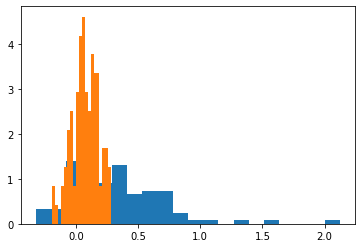

In [11]:
count, bins, ignored = plt.hist(buy_hold_results, 20, density=True)
count, bins, ignored = plt.hist(strategy_results, 20, density=True)

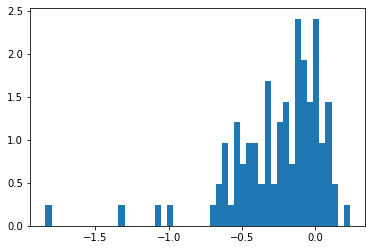

In [12]:
count, bins, ignored = plt.hist(np.array(strategy_results) - np.array(buy_hold_results), 50, density=True)

In [13]:
strat_result = np.array(strategy_results)
strat_result.sort()
print(strat_result)

[-1.92092603e-01 -1.75971839e-01 -1.45946082e-01 -1.09425615e-01
 -1.09027924e-01 -8.64485654e-02 -8.33859209e-02 -8.18138583e-02
 -6.88979015e-02 -6.47772619e-02 -5.70201362e-02 -5.14274139e-02
 -4.94040952e-02 -4.65972792e-02 -4.59320538e-02 -4.39594729e-02
 -3.49418600e-02 -2.77381514e-02 -2.76532728e-02 -8.47643528e-03
 -6.05883794e-03 -1.72753507e-04  4.38806886e-04  6.13656617e-03
  6.17470041e-03  1.06466708e-02  1.76800300e-02  2.01554278e-02
  2.43135042e-02  3.37235436e-02  3.39327220e-02  3.45033132e-02
  3.64919267e-02  3.74538353e-02  3.83012685e-02  4.36483536e-02
  4.54936966e-02  4.54970052e-02  4.67216948e-02  4.67893745e-02
  5.60690612e-02  5.86688515e-02  5.99331153e-02  6.19644342e-02
  6.27634280e-02  6.32216608e-02  6.44011562e-02  6.53427139e-02
  6.81731495e-02  7.03790376e-02  7.53095310e-02  7.54134456e-02
  7.75467864e-02  8.23010873e-02  8.75433830e-02  8.87694658e-02
  1.02105504e-01  1.02209242e-01  1.04060851e-01  1.04846974e-01
  1.09646646e-01  1.12766

In [15]:
df

,open,high,low,close,adjclose,volume,ticker,close daily returns
date,,,,,,,,
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397591,480500,SPY,0.007112
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451389,201300,SPY,0.002119
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720442,529400,SPY,0.010571
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828043,531500,SPY,0.004184
1993-02-05,44.968750,45.062500,44.718750,44.968750,25.810122,492100,SPY,-0.000694
...,...,...,...,...,...,...,...,...
2023-01-06,382.609985,389.250000,379.410004,388.079987,388.079987,104041300,SPY,0.022932
2023-01-09,390.369995,393.700012,387.670013,387.859985,387.859985,73978100,SPY,-0.000567
2023-01-10,387.250000,390.649994,386.269989,390.579987,390.579987,65358100,SPY,0.007013


## Returns

KeyError: 'dca_return'

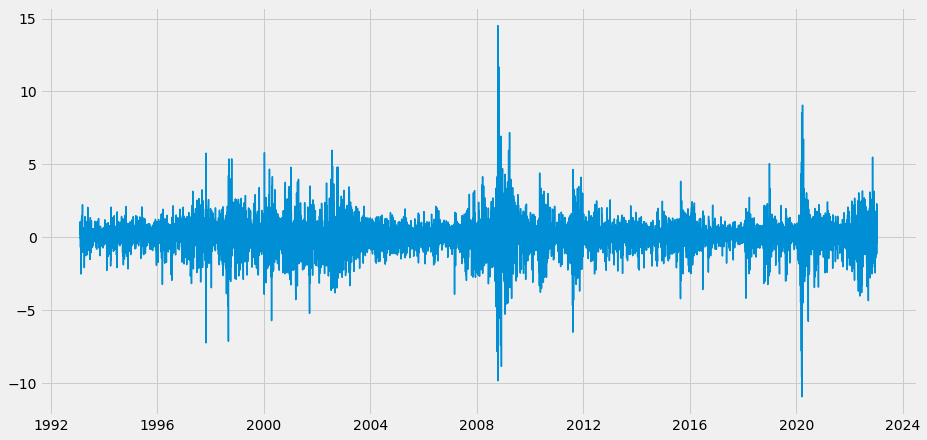

In [16]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(14,7))
    plt.plot(df.index, df['close daily returns'] * 100, linewidth=1.5, label='buy_hold')
    plt.plot(df.index, df['dca_return'] * 100, linewidth=1.5, label='dca')
    
    plt.title("Buy_Hold vs DCA (Returns, SP500, dca every 20 days)")
    plt.ylabel('Returns %')
    plt.legend()

## Drawdown

In [ ]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(14,7))
    plt.plot(df.index, df['buy_hold_drawdown'] * 100, linewidth=1.5, label='buy_hold')
    plt.plot(df.index, df['dca_drawdown'] * 100, linewidth=1.5, label='dca')
    


    plt.title("Buy_Hold vs DCA (Drawdown, SP500, dca every 20 days)")
    plt.ylabel('Drawdown %')
    plt.legend()


## Drawdown Distribution

In [ ]:
buy_hold = sns.displot(df['buy_hold_drawdown'], color='blue', bins=30)
dca = sns.displot(df['dca_drawdown'], color='red', bins=30)

## Annual Returns Dsitribution

In [ ]:
# Rolling Annual Returns
bh_annual_returns = np.array(((df['buy_hold_daily_return'] + 1).rolling(252).apply(np.prod, raw=True) - 1) * 100)
dca_annual_returns = np.array(((df['dca_daily_return'] + 1).rolling(252).apply(np.prod, raw=True) - 1) * 100)

annual_returns = pd.DataFrame({'buy_hold': bh_annual_returns, 'dca': dca_annual_returns})

sns.displot(annual_returns['buy_hold'], color='blue', bins=100)
sns.displot(annual_returns['dca'], color='red', bins=100)

## Statistics

In [ ]:
num_years = len(df) / 252

print('Buy_HODL')
print("Total Returns:              " + "{:.2f}".format(df['buy_hold_return'][-1] * 100) + " %")
print("CAGR:                       " + "{:.2f}".format(((df['buy_hold_return'][-1] + 1) ** (1 / num_years) - 1) * 100) + " %")
print("Maximum Drawdown:          " + "{:.2f}".format(np.min(df['buy_hold_drawdown'] * 100)) + " %")
bh_dr_mean = np.mean(df['buy_hold_daily_return'])
bh_dr_var = np.var(df['buy_hold_daily_return'])
bh_ar_mean = (bh_dr_mean + 1) ** 252 - 1
bh_ar_var = bh_dr_var * np.sqrt(252)
print("Annual Returns Mean:        " + "{:.2f}".format(bh_ar_mean * 100) + " %")
print("Annual Returns Std Dev:     " + "{:.2f}".format(np.sqrt(bh_ar_var) * 100) + " %")
print("99% Worst Annual Drawdown: " + "{:.2f}".format(bh_ar_mean - 2.33 * np.sqrt(bh_ar_var) * 100) + " %")

print()

print('DCA')
print("Total Returns:              " + "{:.2f}".format(df['dca_return'][-1] * 100) + " %")
print("CAGR:                       " + "{:.2f}".format(((df['dca_return'][-1] + 1) ** (1 / num_years) - 1) * 100) + " %")
print("Maximum Drawdown:          " + "{:.2f}".format(np.min(df['dca_drawdown'] * 100)) + " %")
dca_dr_mean = np.mean(df['dca_daily_return'])
dca_dr_var = np.var(df['dca_daily_return'])
dca_ar_mean = (dca_dr_mean + 1) ** 252 - 1
dca_ar_var = dca_dr_var * np.sqrt(252)
print("Annual Returns Mean:        " + "{:.2f}".format(dca_ar_mean * 100) + " %")
print("Annual Returns Std Dev:     " + "{:.2f}".format(np.sqrt(dca_ar_var) * 100) + " %")
print("99% Worst Annual Drawdown: " + "{:.2f}".format(dca_ar_mean - 2.33 * np.sqrt(dca_ar_var) * 100) + " %")